# Árboles de de decisión

Para el desarrollo de este modelo, así como para Random Forest (siguiente punto) utilizaremos el programa R. Para ejecutar código R usaremos la librería rpy2:

In [2]:
%load_ext rpy2.ipython

A continuación cargamos las librerías de R que utilizaremos:

In [3]:
%%R
library(dplyr)
library(tidyverse)
library(tidyr)
library(ggplot2)
library(caret)
library(rpart)
library(rpart.plot)
library(rsample)
library(MLmetrics)
library(randomForest)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ stringr 1.4.0
✔ tidyr   1.0.2     ✔ forcats 0.5.0
✔ readr   1.3.1     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: lattice

R[write to console]: 
Attaching package: ‘caret’


R[write to console]: The following object is masked from ‘package:purrr’:

    lift


R[write to console]: 
Attaching package: ‘MLmetrics’


R[write to console]: The following objects are masked 

Cargamos los datos y categorizamos la variable T.H.I (Total Household Income) en los tres niveles socioeconómicos definidos anteriormente: Bajo (entre 0 y 350.000 pesos filipinos), Medio (entre 350.000 y 700.000 pesos filipinos) y Alto (de 700.000 pesos filipinos en adelante).

Además, una vez categorizada la variable T.H.I, dividimos los datos en conjuntos de train, test y validación. Para ello, dado que nuestros datos están desequilibrados (la mayoría de observaciones se encuentra en el nivel socioeconómico Bajo) lo tendremos en cuenta para que la proporción de esta variable se mantenga en cada uno de los conjuntos creados:

In [4]:
%%R
path <- '../Downloads/total_datos_philipines.csv'
datos <-read.csv(path)



#Categorizamos la variable T.H.I (nivel socioeconómico alto, medio, bajo).
datos$income_category <- cut(datos$T.H.I, breaks=c(0,350000,700000,1000000000), labels=c("Bajo","Medio","Alto"))
datos = datos %>% select(-T.H.I)

set.seed(111)
#Indices del conjunto de train + test
training <- createDataPartition(datos$income_category, p = .8, list = FALSE, times = 1)
#Conjunto de train +  test
datos_t <- slice(datos, training)
#Conjunto de validación
datos_validation <- slice(datos, -training)
#Indices de conjunto de test
test <- createDataPartition(datos_t$income_category, p = .3, list = FALSE, times = 1)
#Conjunto de test
datos_test <- slice(datos_t, test)
#Conjunto de train
datos_train <- slice(datos_t, -test)




A continuación entrenaremos un modelo de árbol de decisión con los valores por defecto, cogiendo las 43 variables de nuestro dataset:

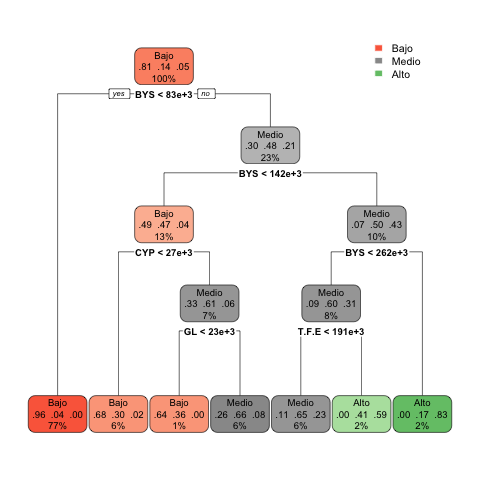

In [4]:
%%R
d_tree <- rpart(income_category~., data = datos_train, method = 'class')

rpart.plot(d_tree)

En este árbol de decisión podemos observar cómo:

* El modelo selecciona como variables más relevantes los gastos en bienes y servicios, los gastos en comida y los gastos de lujo.
* En el caso de los gastos varios en bienes y servicios, cuando estos no superan los83.000 pesos filipinos, existe una probabilidad del 96% de que la familia pertenezca al nivel socioeconómico. Por otro lado, si estos gastos superan los 262.000 pesos, la familia tendrá un nivel socioeconómico alto con una probabilidad del 83%.
No obstante, estas variables podrían variar según el conjunto de train que usemos por lo que la selección de variables relevantes se tratará con más detalle en el modelo Random Forest.

Evaluamos el modelo creado con los valores por defecto:



In [5]:
%%R
#Generamos la matriz de confusión resultante con los datos de test.
confusionMatrix(predict(d_tree, datos_test,type = "class"), datos_test$income_category, mode= "prec_recall")


Confusion Matrix and Statistics

          Reference
Prediction Bajo Medio Alto
     Bajo  1878   144    8
     Medio   62   165   42
     Alto     0    31   71

Overall Statistics
                                          
               Accuracy : 0.8805          
                 95% CI : (0.8668, 0.8932)
    No Information Rate : 0.808           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6             
                                          
 Mcnemar's Test P-Value : 3.468e-09       

Statistics by Class:

                     Class: Bajo Class: Medio Class: Alto
Precision                 0.9251      0.61338     0.69608
Recall                    0.9680      0.48529     0.58678
F1                        0.9461      0.54187     0.63677
Prevalence                0.8080      0.14161     0.05040
Detection Rate            0.7822      0.06872     0.02957
Detection Prevalence      0.8455      0.11204     0.04248
Bal

En este caso, conseguimos un accuracy alto (88%). Si nos fijamos en las métricas individuales de cada clase, el F1 Score es mucho mayor para el nivel bajo que para el medio y el alto.
Si observamos la matriz de confusión, vemos que los errores se dan generalmente confundiendo los factores Bajo y Medio. 

Vamos a intentar mejorar estos resultados ajustando el parametro cp. Si disminuimos su valor, se reduce la mínima mejora exigida para que se abra un nuevo nodo  y por tanto dejaremos que el árbol se expanda con mayor facilidad. Analizamos los valores en torno a los que se mueve nuestro árbol por defecto:


Classification tree:
rpart(formula = income_category ~ ., data = datos_train, method = "class")

Variables actually used in tree construction:
[1] BYS   CYP   GL    T.F.E

Root node error: 1074/5600 = 0.19179

n= 5600 

        CP nsplit rel error  xerror     xstd
1 0.210428      0   1.00000 1.00000 0.027432
2 0.065177      1   0.78957 0.79423 0.025037
3 0.018622      4   0.59404 0.64711 0.022973
4 0.014898      5   0.57542 0.63780 0.022830
5 0.010000      6   0.56052 0.63315 0.022758


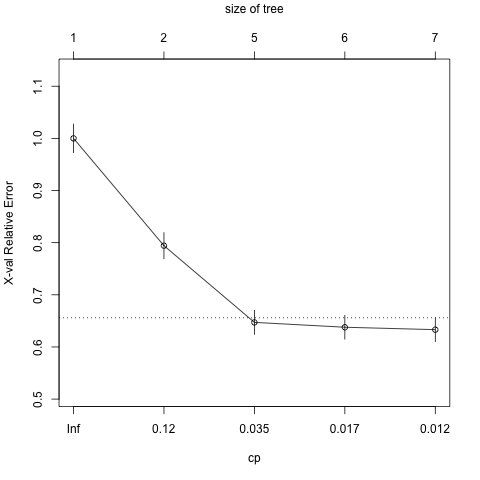

In [6]:
%%R
printcp(d_tree)

plotcp(d_tree)


Creamos un modelo menos restrictivo con un cp de 0.005:

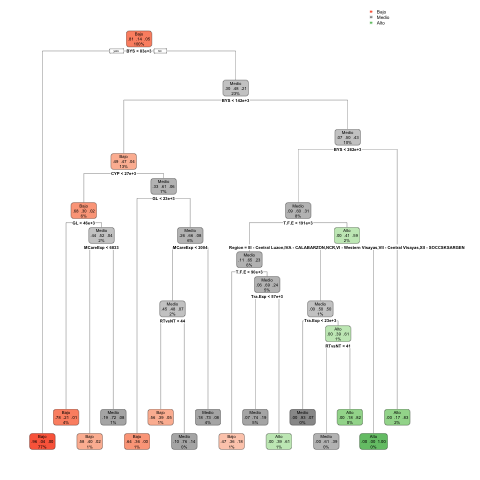

In [7]:
%%R 
d_tree1 <- rpart(income_category ~ ., data = datos_train, method = "class", cp=0.005)
rpart.plot(d_tree1)


Vemos como en este caso, el árbol se expande mucho más que en el modelo anterior, presentando un mayor número de ramas y nodos terminales. Si evaluamos los resultados del modelo con los datos de test:

In [8]:
%%R 
confusionMatrix(predict(d_tree1, datos_test,type = "class"), datos_test$income_category, mode= "prec_recall")



Confusion Matrix and Statistics

          Reference
Prediction Bajo Medio Alto
     Bajo  1902   154    8
     Medio   38   162   46
     Alto     0    24   67

Overall Statistics
                                          
               Accuracy : 0.8875          
                 95% CI : (0.8742, 0.8999)
    No Information Rate : 0.808           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6109          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: Bajo Class: Medio Class: Alto
Precision                 0.9215      0.65854     0.73626
Recall                    0.9804      0.47647     0.55372
F1                        0.9500      0.55290     0.63208
Prevalence                0.8080      0.14161     0.05040
Detection Rate            0.7922      0.06747     0.02791
Detection Prevalence      0.8596      0.10246     0.03790
Bal

Si bien presenta cierta mejora, no consideramos que sea significativa. Además, al ser un modelo más complejo pierde capacidad explicativa respecto al anterior.

# Random Forest

En primer lugar creamos un modelo con los valores por defecto (500 árboles, 6 variables candidatas en cada ramificación,  y las 43 variables posibles:

In [17]:
%%R
modelo_rf <- randomForest(income_category ~ ., data = datos_train, importance = TRUE, na.action=na.exclude)

confusionMatrix(predict(modelo_rf, datos_test,type = "class"), datos_test$income_category, mode= "prec_recall")



Confusion Matrix and Statistics

          Reference
Prediction Bajo Medio Alto
     Bajo  1587    86    2
     Medio   44   156   44
     Alto     0    14   42

Overall Statistics
                                          
               Accuracy : 0.9038          
                 95% CI : (0.8899, 0.9164)
    No Information Rate : 0.8258          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6593          
                                          
 Mcnemar's Test P-Value : 8.151e-07       

Statistics by Class:

                     Class: Bajo Class: Medio Class: Alto
Precision                 0.9475      0.63934     0.75000
Recall                    0.9730      0.60938     0.47727
F1                        0.9601      0.62400     0.58333
Prevalence                0.8258      0.12962     0.04456
Detection Rate            0.8035      0.07899     0.02127
Detection Prevalence      0.8481      0.12354     0.02835
Bal

Con el modelo de valores por defecto, mejoramos la precisión respecto al modelo de árbol de decisión en un 2% para las clases bajo y medio, y en un 6% para la clase alta.

A continuación, ajustaremos los siguientes parámetros del modelo de manera que optimicen el out-of-bag error. Definimos las funciones que vamos a utilizar:

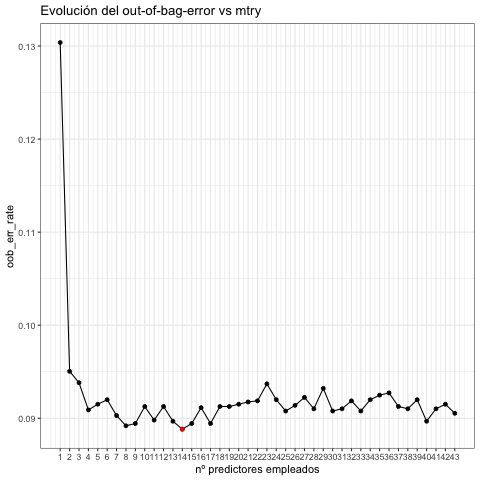

In [18]:
%%R

#Analizamos la evolución del error (out-of-bag clasification error) según el número de predictores (variables) candidatas evaluadas en cada división.
tuning_rf_mtry <- function(df, y, ntree = 200){
  
  # Argumentos:
  #   df = data frame con los predictores y variable respuesta
  #   y  = nombre de la variable respuesta
  #   ntree = número de árboles creados en el modelo randomForest
  
  require(dplyr)
  max_predictores <- ncol(df) - 1
  n_predictores   <- rep(NA, max_predictores)
  oob_err_rate    <- rep(NA, max_predictores)
  for (i in 1:max_predictores) {
    set.seed(123)
    f <- formula(paste(y,"~ ."))
    modelo_rf <- randomForest(formula = f, data = df, mtry = i, ntree = ntree, na.action=na.exclude)
    n_predictores[i] <- i
    oob_err_rate[i] <- tail(modelo_rf$err.rate[, 1], n = 1)
  }
  results <- data_frame(n_predictores, oob_err_rate)
  return(results)
}

hiperparametro_mtry <-  tuning_rf_mtry(df = datos, y = "income_category")
hiperparametro_mtry %>% arrange(oob_err_rate)
ggplot(data = hiperparametro_mtry, aes(x = n_predictores, y = oob_err_rate)) +
  scale_x_continuous(breaks = hiperparametro_mtry$n_predictores) +
  geom_line() +
  geom_point() +
  geom_point(data = hiperparametro_mtry %>% arrange(oob_err_rate) %>% head(1),
             color = "red") +
  labs(title = "Evolución del out-of-bag-error vs mtry",
       x = "nº predictores empleados") +
  theme_bw()

#Resultado: mtry=8,14
#Analizamos la evolución del error (out-of-bag clasification error) según el tamaño mínimo de los nodos terminales.


In [ ]:
%%R

#Analizamos la evolución del error (out-of-bag clasification error) según el número de predictores (variables) candidatas evaluadas en cada división.
tuning_rf_mtry <- function(df, y, ntree = 200){
  
  # Argumentos:
  #   df = data frame con los predictores y variable respuesta
  #   y  = nombre de la variable respuesta
  #   ntree = número de árboles creados en el modelo randomForest
  
  require(dplyr)
  max_predictores <- ncol(df) - 1
  n_predictores   <- rep(NA, max_predictores)
  oob_err_rate    <- rep(NA, max_predictores)
  for (i in 1:max_predictores) {
    set.seed(123)
    f <- formula(paste(y,"~ ."))
    modelo_rf <- randomForest(formula = f, data = df, mtry = i, ntree = ntree, na.action=na.exclude)
    n_predictores[i] <- i
    oob_err_rate[i] <- tail(modelo_rf$err.rate[, 1], n = 1)
  }
  results <- data_frame(n_predictores, oob_err_rate)
  return(results)
}

hiperparametro_mtry <-  tuning_rf_mtry(df = datos, y = "income_category")
hiperparametro_mtry %>% arrange(oob_err_rate)
ggplot(data = hiperparametro_mtry, aes(x = n_predictores, y = oob_err_rate)) +
  scale_x_continuous(breaks = hiperparametro_mtry$n_predictores) +
  geom_line() +
  geom_point() +
  geom_point(data = hiperparametro_mtry %>% arrange(oob_err_rate) %>% head(1),
             color = "red") +
  labs(title = "Evolución del out-of-bag-error vs mtry",
       x = "nº predictores empleados") +
  theme_bw()

#Resultado: mtry=6
#Analizamos la evolución del error (out-of-bag clasification error) según el tamaño mínimo de los nodos terminales.

tuning_rf_nodesize <- function(df, y, size = NULL, ntree = 200){
  
  # Argumentos:
  #   df = data frame con los predictores y variable respuesta
  #   y  = nombre de la variable respuesta
  #   sizes = tamaños evaluados
  #   ntree = número de árboles creados en el modelo randomForest
  
  require(dplyr)
  if (is.null(size)){
    size <- seq(from = 1, to = nrow(df), by = 5)
  }
  oob_err_rate <- rep(NA, length(size))
  for (i in seq_along(size)) {
    set.seed(321)
    f <- formula(paste(y,"~ ."))
    modelo_rf <- randomForest(formula = f, data = df, mtry = 6, ntree = ntree,
                              nodesize = i)
    oob_err_rate[i] <- tail(modelo_rf$err.rate[, 1], n = 1)
  }
  results <- data_frame(size, oob_err_rate)
  return(results)
}

hiperparametro_nodesize <-  tuning_rf_nodesize(df = datos, y = "income_category",
                                               size = c(1:20))
hiperparametro_nodesize %>% arrange(oob_err_rate)

ggplot(data = hiperparametro_nodesize, aes(x = size, y = oob_err_rate)) +
  scale_x_continuous(breaks = hiperparametro_nodesize$size) +
  geom_line() +
  geom_point() +
  geom_point(data = hiperparametro_nodesize %>% arrange(oob_err_rate) %>% head(1),
             color = "red") +
  labs(title = "Evolución del out-of-bag-error vs nodesize",
       x = "nº observaciones en nodos terminales") +
  theme_bw()

#Resultado:nodesize=3

#Evolución del modelo en función del número de árboles
modelo_randomforest_tun <- randomForest(income_category ~ ., data = datos, mtry = 6, ntree = 500,
                                        importance = TRUE, nodesize = 3,na.action = na.exclude)

oob_err_rate <- data.frame(oob_err_rate = modelo_randomforest_tun$err.rate[, 1],
                           arboles = seq_along(modelo_randomforest_tun$err.rate[, 1]))
ggplot(data = oob_err_rate, aes(x = arboles, y = oob_err_rate )) +
  geom_line() +
  labs(title = "Evolución del out-of-bag-error vs número árboles",
       x = "nº árboles") +
  theme_bw()
#En torno a los 200 árboles el modelo se estabiliza. Resultado: ntree=200

#Ajustamos finalmente el modelo:
set.seed(567)
modelo_randomforest <- randomForest(income_category ~ ., data = datos_train, mtry = 6, ntree = 200,
                                    importance = TRUE, nodesize = 3,
                                    norm.votes = TRUE, na.action = na.omit)
modelo_randomforest
#Predecimos con test
table_test_randomforest=table(pred = predict(modelo_randomforest, datos_test,type = "class"), obs = datos_test$income_category)
accuracy_test_randomforest <- sum(diag(table_test_randomforest)) / sum(table_test_randomforest)
accuracy_test_randomforest

#importancia de variables predictoras
library(tidyverse)
library(ggpubr)
importancia_pred <- as.data.frame(importance(modelo_randomforest, scale = TRUE))
importancia_pred <- rownames_to_column(importancia_pred, var = "variable")
p1 <- ggplot(data=importancia_pred, aes(x=reorder(variable, MeanDecreaseAccuracy),
                                        y = MeanDecreaseAccuracy,
                                        fill = MeanDecreaseAccuracy)) +
  labs(x = "variable", title = "Aumento de Accuracy") +
  geom_col() +
  coord_flip() +
  theme_bw() +
  theme(legend.position = "bottom")

p2 <- ggplot(data = importancia_pred, aes(x = reorder(variable, MeanDecreaseGini),
                                          y = MeanDecreaseGini,
                                          fill = MeanDecreaseGini)) +
  labs(x = "variable", title = "Reducción de pureza (Gini)") +
  geom_col() +
  coord_flip() +
  theme_bw() +
  theme(legend.position = "bottom")
ggarrange(p1, p2)





In [5]:
%%R
#Ajustamos finalmente el modelo:
set.seed(567)
modelo_randomforest <- randomForest(income_category ~ ., data = datos_train, mtry = 6, ntree = 200,
                                    importance = TRUE, nodesize = 3,
                                    norm.votes = TRUE, na.action = na.omit)

#Predecimos con test
confusionMatrix(predict(modelo_randomforest, datos_test,type = "class"), datos_test$income_category, mode= "prec_recall")




Confusion Matrix and Statistics

          Reference
Prediction Bajo Medio Alto
     Bajo  1589    81    0
     Medio   42   163   46
     Alto     0    12   42

Overall Statistics
                                          
               Accuracy : 0.9084          
                 95% CI : (0.8948, 0.9207)
    No Information Rate : 0.8258          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6773          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Bajo Class: Medio Class: Alto
Precision                 0.9515      0.64940     0.77778
Recall                    0.9742      0.63672     0.47727
F1                        0.9627      0.64300     0.59155
Prevalence                0.8258      0.12962     0.04456
Detection Rate            0.8046      0.08253     0.02127
Detection Prevalence      0.8456      0.12709     0.02734
Bal

### Selección de variables

A partir del modelo Random Forest podemos analizar las variables más relevantes de nuestro dataset, ya que ahora mismo tenemos 43 variables. Además de ser un número muy elevado, dada la naturaleza de nuestras variables es muy probable que estén muchas de ellas presenten algún tipo de relación y por ello no aporten información al modelo.
Para seleccionar las variables relevantes, estudiaremos su importancia a la hora de clasificar los datos adecuadamente en función de la variable objetivo (nivel socioeconómico):

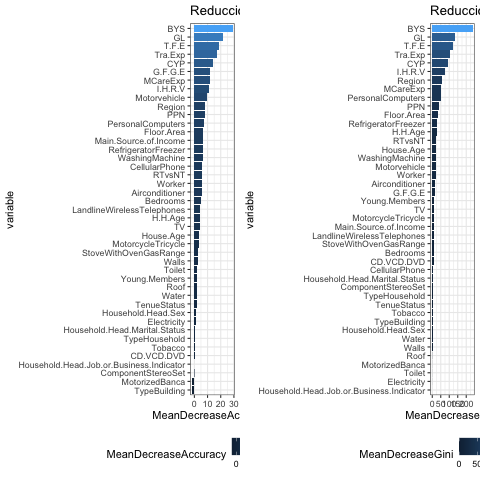

In [11]:
%%R
#importancia de variables predictoras
library(tidyverse)
library(ggpubr)
importancia_pred <- as.data.frame(importance(modelo_randomforest, scale = TRUE))
importancia_pred <- rownames_to_column(importancia_pred, var = "variable")
p1 <- ggplot(data=importancia_pred, aes(x=reorder(variable, MeanDecreaseAccuracy),
                                        y = MeanDecreaseAccuracy,
                                        fill = MeanDecreaseAccuracy)) +
  labs(x = "variable", title = "Reducción media de la precisión") +
  geom_col() +
  coord_flip() +
  theme_bw() +
  theme(legend.position = "bottom")

p2 <- ggplot(data = importancia_pred, aes(x = reorder(variable, MeanDecreaseGini),
                                          y = MeanDecreaseGini,
                                          fill = MeanDecreaseGini)) +
  labs(x = "variable", title = "Reducción de pureza (Gini)") +
  geom_col() +
  coord_flip() +
  theme_bw() +
  theme(legend.position = "bottom")
ggarrange(p1, p2)







En el gráfico de la izquierda se pueden observar las variables ordenadas en función de su importancia si tenemos en cuenta la disminución media de accuracy. Esta tiene en cuenta cuánto disminuye el accuracy medio del bosque de árboles (calculado sobre el out-of-bag error) al sacar la variable del modelo. Cuanto mayor es la disminución, más importante se considera dicha variable.

En este caso, las variables que producen una mayor disminución media de accuracy son:

* Gasto en bienes y servicios (BYS)
* Gasto en productos/servicios de lujo (GL)
* Gasto total en comida (TFE)
* Gasto en transporte (Tra.Exp)
* Gasto en carne y pescado (CYP)
* Gasto en cultivos y jardinería (GFGE)
 
En el gráfico de la derecha, la medida que tenemos en cuenta para seleccionar la importancia de las variables es la reducción de la impureza de Gini. Es decir, las variables que más disminuyen este valor contribuyen en mayor medida a crear nodos "más puros", es decir más homogéneos y, por tanto clasifican mejor los datos en función de la variable objetivo.

En este caso, las variables que producen una mayor disminución media de accuracy son:

* Gasto en bienes y servicios (BYS)
* Gasto en productos/servicios de lujo (GL)
* Gasto total en comida (TFE)
* Gasto en transporte (Tra.Exp)
* Gasto en carne y pescado (CYP)
* Valor del alquiler de la casa (IHRV)
 
Vemos como en ambos casos coinciden en la mayoría de variables.
 
Finalmente, tras haber optimizado los parámetros del modelo y analizado las variables más relevantes, entrenaremos el modelo con los parámetros óptimos y utilizando únicamente las variables más relevantes:

In [13]:
%%R
#Ajustamos finalmente el modelo:

modelo_randomforest_f <- randomForest(income_category ~ BYS + GL + T.F.E + Tra.Exp + CYP + I.H.R.V + G.F.G.E, data = datos_train, mtry = 6, ntree = 200,
                                    importance = TRUE, nodesize = 3,
                                    norm.votes = TRUE, na.action = na.omit)

#Predecimos con test
confusionMatrix(predict(modelo_randomforest_f, datos_test,type = "class"), datos_test$income_category, mode= "prec_recall")



Confusion Matrix and Statistics

          Reference
Prediction Bajo Medio Alto
     Bajo  1871   109    7
     Medio   69   211   51
     Alto     0    20   63

Overall Statistics
                                          
               Accuracy : 0.8934          
                 95% CI : (0.8803, 0.9054)
    No Information Rate : 0.808           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6561          
                                          
 Mcnemar's Test P-Value : 1.738e-06       

Statistics by Class:

                     Class: Bajo Class: Medio Class: Alto
Precision                 0.9416      0.63746     0.75904
Recall                    0.9644      0.62059     0.52066
F1                        0.9529      0.62891     0.61765
Prevalence                0.8080      0.14161     0.05040
Detection Rate            0.7793      0.08788     0.02624
Detection Prevalence      0.8276      0.13786     0.03457
Bal

En este caso vemos como prácticamente no perdemos accuracy. En el caso de F1 Score, si bien no perdemos apenas para la clase Bajo y Medio, conseguimos una mejora del 2% para la clase Alto